In [ ]:
!pip install d2l

In [2]:
import torch
import torch.nn as nn
from d2l import torch as d2l

Load the dataset

In [3]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

# Gated Recurrent Units (GRU)

[Behind the scenes](https://d2l.ai/chapter_recurrent-modern/gru.html)

Two gates:

- Reset Gate: allow us to control how much of the previous state we might still want to remember.

- Update Gate: allow us to control how much of the new state is just a copy of the old state.

Mathematically, for a given time step $t$, input minibatch is $\textbf{X}_t \in \mathbb{R}^{nxd}$ (n:number of batch size, d:number of inputs (vocab_size)) and the hidden state of the previous time step is $\textbf{H}_{t-1} \in \mathbb{R}^{nxh}$. Then, the reset gate $\textbf{R}_t \in \mathbb{R}^{nxh}$ and the update gate $\textbf{Z}_t \in \mathbb{R}^{nxh}$ are computed as follows:

$\textbf{R}_t = \sigma(\textbf{X}_t\textbf{W}_{xr} + \textbf{H}_{t-1}\textbf{W}_{hr} + \textbf{b}_r)$

$\textbf{Z}_t = \sigma(\textbf{X}_t\textbf{W}_{xz} + \textbf{H}_{t-1}\textbf{W}_{hz} + \textbf{b}_z)$

where, 
- $\textbf{W}_{xr}$ , $\textbf{W}_{xz}$ $\in \mathbb{R}^{dxh}$

- $\textbf{W}_{hr}$ , $\textbf{W}_{hz}$ $\in \mathbb{R}^{hxh}$

- $\textbf{b}_{r}$ , $\textbf{b}_{z}$ $\in \mathbb{R}^{1xh}$


**Candidate Hidden State**:

$\tilde{\textbf{H}}_t = tanh(\textbf{X}_t\textbf{W}_{xh} + (\textbf{R}_t \odot \textbf{H}_{t-1}) \textbf{W}_{hh} + \textbf{b}_h)$

where, 
- $\textbf{W}_{xh} \in \mathbb{R}^{dxh}$
- $\textbf{W}_{hh} \in \mathbb{R}^{hxh}$
- $\textbf{b}_{h} \in \mathbb{R}^{1xh}$


**Hidden State**:
Finally, we incorporate the effect of the update gate $\textbf{Z}_t$

$\textbf{H}_t = \textbf{Z}_t \odot \textbf{H}_{t-1} + (1 - \textbf{Z}_t \odot \tilde{\textbf{H}_t})$


When $\textbf{Z}_t$ is close to 1, we simply retain the old state.

When $\textbf{Z}_t$ is close to 0, the new latent state $\textbf{H}_t$ approaches the candidate latent state $\tilde{\textbf{H}_t}$. 

If the update gate has been close to 1 for all the time steps of an entire subsequence, the old hidden state at the time step of its beginning will be easily retained and passed to its end, regardless of the length of the subsequence.

# Initializing model parameters


In [4]:
def get_params(vocab_size, num_hiddens, device):
  num_inputs = num_outputs = vocab_size

  def normal(shape):
    return torch.randn(size=shape, device=device) * 0.01
  
  def three():
    return (normal((num_inputs, num_hiddens)), normal((num_hiddens, num_hiddens)), torch.zeros(num_hiddens, device=device))
  
  W_xz, W_hz, b_z = three() # 'Update gate' parameters
  W_xr, W_hr, b_r = three() # 'Reset gate' parameters
  W_xh, W_hh, b_h = three() # 'Candidate hidden state' parameters

  # Output layer parameters
  W_hy = normal((num_hiddens, num_outputs))
  b_y = torch.zeros(num_outputs, device=device)

  # Attach gradients
  params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hy, b_y]
  for param in params:
    param.requires_grad_(True)
  return params

# Defining the model

In [5]:
# init hidden state

def init_gru_state(batch_size, num_hiddens, device):
  return (torch.zeros((batch_size, num_hiddens), device=device),)

def gru(inputs, state, params):
  # shape of inputs: (num_steps, batch_size, vocab_size)
  W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hy, b_y = params
  H, = state
  outputs = []

  for X in inputs:
    # Shape of X: (batch_size, vocab_size)
    Z = torch.sigmoid( (X @ W_xz) + (H @ W_hz) + b_z ) 
    R = torch.sigmoid( (X @ W_xr) + (H @ W_hr) + b_r )
    H_tilda = torch.tanh( (X @ W_xh) + ( (R * H) @ W_hh ) + b_h)
    H = Z * H + (1 - Z) * H_tilda # (batch_size, num_hiddens)
    Y = H @ W_hy + b_y   # (batch_size, vocab_size) 
    outputs.append(Y)

  return torch.cat(outputs, dim=0), (H,) # shape: (num_steps x batch_size, vocab_size), ((batch_size, num_hiddens), )

# Training and Prediction

perplexity 1.1, 45161.1 tokens/sec on cuda
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


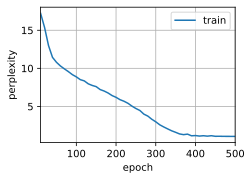

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vocab_size, num_hiddens = len(vocab), 256
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(vocab_size, num_hiddens, device, get_params, init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

# Concise Implementation

[GRU Pytorch](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)

perplexity 1.0, 410990.4 tokens/sec on cuda
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


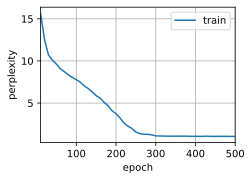

In [8]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens, num_layers=1)
model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)